In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as data
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn
from google.colab.patches import cv2_imshow
import cv2
import torch
from tqdm.auto import tqdm
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
import shutil
import random
root_dir = "/content/drive/My Drive/train"
classes_dir = ['basketball_court', 'beach', 'forest', 'others', 'railway', 'swimming_pool', 'tennis_court']
val_ratio = 0.20
for cls in classes_dir:
    os.makedirs(root_dir +'/train/' + cls)
    os.makedirs(root_dir +'/val/' + cls)
    src = root_dir + "/" + cls 
    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, val_FileNames= np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio))])
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]
    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train/' + cls)

    for name in val_FileNames:
        shutil.copy(name, root_dir +'/val/' + cls)

Total images:  80
Training:  64
Validation:  16
Total images:  80
Training:  64
Validation:  16
Total images:  80
Training:  64
Validation:  16
Total images:  80
Training:  64
Validation:  16
Total images:  80
Training:  64
Validation:  16
Total images:  80
Training:  64
Validation:  16
Total images:  80
Training:  64
Validation:  16


In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.3,
        vertical_flip=True,
        horizontal_flip=True,
        fill_mode='constant')
classes = ['basketball_court', 'beach', 'forest', 'others', 'railway', 'swimming_pool', 'tennis_court']
for cls in classes:
  for filename in tqdm(os.listdir("/content/drive/My Drive/train/train/"+cls)):
    img = load_img("/content/drive/My Drive/train/train/"+cls+"/"+filename)  
    x = img_to_array(img) 
    x = x.reshape((1,) + x.shape) 
    i = 0
    for batch in datagen.flow(x, batch_size=1,
                              save_to_dir="/content/drive/My Drive/train/train/"+cls, save_prefix=filename, save_format='jpeg'):
        i += 1
        if i > 10:
            break  

100%|██████████| 64/64 [00:18<00:00,  3.53it/s]


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(5, translate=(0.2,0.2), scale=(0.9,1.2), shear=(10,10), resample=False, fillcolor=0),
        transforms.RandomPerspective(distortion_scale=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.3794, 0.3961, 0.3725], [0.1846, 0.1853, 0.1804])
    ]),
    'validation': transforms.Compose([                                    
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.3794, 0.3961, 0.3725], [0.1846, 0.1853, 0.1804])
    ]),
}

In [ ]:
train_dataset = datasets.ImageFolder("/content/drive/My Drive/train/train/", data_transforms['train'])
val_dataset = datasets.ImageFolder("/content/drive/My Drive/train/val", data_transforms['validation'])


dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(
                                    train_dataset,                                        
                                    batch_size=32,
                                    shuffle=True, num_workers=4)
dataloaders['validation'] = torch.utils.data.DataLoader(
                                    val_dataset,                                        
                                    batch_size=4,
                                    shuffle=True, num_workers=4)

dataset_sizes = {}
dataset_sizes['train'] = len(train_dataset)
dataset_sizes['validation'] = len(val_dataset)
classes = train_dataset.classes

In [ ]:
print(dataset_sizes)

{'train': 5374, 'validation': 112}


In [ ]:
data = next(iter(dataloaders['train']))
data[0].mean(axis = (0, 2, 3)), data[0].std(axis = (0, 2, 3))

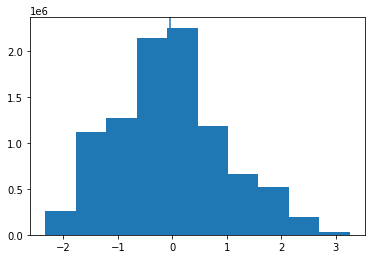

In [ ]:
plt.hist(data[0].flatten())
plt.axvline(data[0].mean())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


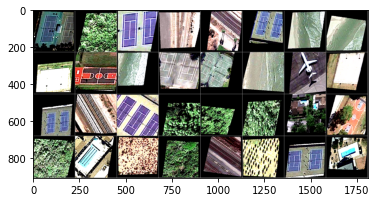

tennis_court forest tennis_court railway


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
dataiter = iter(dataloaders['train'])
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(64)
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.ConvLayer4 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.ConvLayer5 = nn.Sequential(
            nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(inplace = True),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.FC = nn.Sequential(
            nn.Linear(100352, 1000),
            nn.LeakyReLU(inplace = True),
            nn.Dropout(p=0.5),
            nn.Linear(1000, 7)
        )
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)
        x = self.ConvLayer4(x)
        x = self.ConvLayer5(x)
        x = x.view(x.size(0), -1)
        x = self.FC(x)
        return F.log_softmax(x, dim = 1)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = AlexNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_fc = torch.optim.SGD([param for (name, param) in model.named_parameters() if "FC" in name], lr=0.0001, weight_decay=0.05)
optimizer_conv = torch.optim.SGD([param for (name, param) in model.named_parameters() if "FC" not in name], lr=0.001, weight_decay=0.05)
exp_lr_scheduler_fc = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_fc)
exp_lr_scheduler_conv = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_conv)

In [ ]:
model

GNRNet(
  (ConvLayer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (ConvLayer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3),

In [ ]:
def train_model(model, criterion, optimizer_fc, optimizer_conv, scheduler_fc, scheduler_conv, num_epochs=10,resume=None, model_name='AlexNet'):
    since = time.time()
    train_loss = []
    val_loss = []
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'validation']:#
            if phase == 'train':
                model.train()  
            else:
                model.eval() 
            running_loss = 0.0
            running_corrects = 0
            ground_truth = []
            predictions = []
            confidence = []
            new_soft = []
            new_live_images = []
            new_ground_truth = []
            new_predictions = []
            temp = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer_fc.zero_grad()
                optimizer_conv.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)

                    _, preds = torch.max(outputs, dim=1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer_fc.step()
                        optimizer_conv.step()

                    else:
                        ground_truth.append(labels)
                        predictions.append(preds)
                        conf_scores,idx = torch.max(torch.nn.functional.softmax(outputs,dim=1),dim=1)
                        confidence.append(conf_scores)

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)                
            if phase == 'validation':
                scheduler_fc.step(running_loss)
                scheduler_conv.step(running_loss)
            if phase == 'validation':
                a,b,c = torch.cat(ground_truth), torch.cat(predictions), torch.cat(confidence)
                a = a.detach().cpu().numpy()
                b = b.detach().cpu().numpy()
                c = c.detach().cpu().numpy()

                a = [0 if x==0 else 1 for x in a]
                b = [0 if x==0 else 1 for x in b]
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == "train":
              train_loss.append(epoch_loss)
            elif phase == "test":
              test_loss.append(epoch_loss)
            else:
              val_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                model_weight_dir = './weights_'+model_name
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    return model, train_loss, val_loss

In [ ]:
model_training = train_model(model, criterion, 
                              optimizer_fc, optimizer_conv, 
                              exp_lr_scheduler_fc, exp_lr_scheduler_conv,
                              num_epochs=100)

Epoch 0/29
----------
train Loss: 1.1303 Acc: 0.6223
validation Loss: 0.5566 Acc: 0.8304

Epoch 1/29
----------
train Loss: 0.5578 Acc: 0.8312
validation Loss: 0.3676 Acc: 0.8750

Epoch 2/29
----------
train Loss: 0.4028 Acc: 0.8643
validation Loss: 0.2686 Acc: 0.9018

Epoch 3/29
----------
train Loss: 0.3279 Acc: 0.8930
validation Loss: 0.2181 Acc: 0.9286

Epoch 4/29
----------
train Loss: 0.2707 Acc: 0.9114
validation Loss: 0.2214 Acc: 0.9018

Epoch 5/29
----------
train Loss: 0.2324 Acc: 0.9256
validation Loss: 0.1814 Acc: 0.9196

Epoch 6/29
----------
train Loss: 0.2052 Acc: 0.9362
validation Loss: 0.1486 Acc: 0.9375

Epoch 7/29
----------
train Loss: 0.1915 Acc: 0.9367
validation Loss: 0.1420 Acc: 0.9464

Epoch 8/29
----------
train Loss: 0.1626 Acc: 0.9494
validation Loss: 0.1579 Acc: 0.9464

Epoch 9/29
----------
train Loss: 0.1453 Acc: 0.9555
validation Loss: 0.1166 Acc: 0.9643

Epoch 10/29
----------
train Loss: 0.1297 Acc: 0.9645
validation Loss: 0.1799 Acc: 0.9375

Epoch 11/

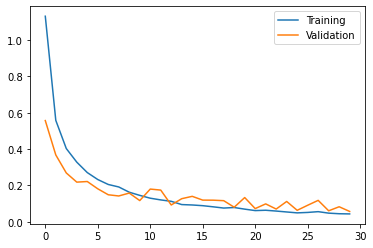

In [ ]:
import matplotlib.patches as mpatches
plt.plot(model_training[1], label="Training")
plt.plot(model_training[2], label="Validation")
plt.legend()

In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/model.pt")

In [ ]:
from PIL import Image

data = pd.DataFrame(columns=["ImageID", "Label"])
for filename in tqdm(os.listdir("/content/drive/My Drive/test_set")):
  img = Image.open("/content/drive/My Drive/test_set/"+filename)
  img = data_transforms['validation'](img)
  img = torch.reshape(img, (1, 3, 224, 224))
  input_img = img.to(device)
  outputs = model(input_img)
  outputs = outputs.cpu()
  outputs = list(outputs[0].detach().numpy())
  pred_class = classes[outputs.index(max(outputs))]
  if pred_class =='basketball_court':
    pred_label = 1
  elif pred_class == 'beach':
    pred_label = 2
  elif pred_class == 'forest':
    pred_label = 3
  elif pred_class == 'railway':
    pred_label = 4
  elif pred_class == 'tennis_court':
    pred_label = 5
  elif pred_class == 'swimming_pool':
    pred_label = 6
  elif pred_class == 'others':
    pred_label = 7
  
  data = data.append({"ImageID": int(filename[:4]),
                      "Label": pred_label}, ignore_index=True)

data = data.sort_values(by='ImageID', ascending=1)
data.to_csv("submission.csv", index=False)

100%|██████████| 95/95 [00:27<00:00,  3.39it/s]
